## Lab 3: Dimensional modelling and ETL data processing Medical Imaging

**Team Members**:

- Yago Estévez Figueiras
- Andrea Real Blanco
- Francisco Manuel Vázquez Fernández

*Kaggle Dataset*: [CT Medical Images](https://www.kaggle.com/datasets/kmader/siim-medical-images?select=dicom_dir)

---

The objective of this lab practice is to implement a **Dimensional Model** to support the analysis of medical images. Specifically, we target the analysis of **radiology images** pertaining to patients diagnosed with **Lung Adenocarcinoma**, the most prevalent form of lung cancer. The **Star Schema** is designed to provide insights into the following dimensions: imaging quality, equipment performance, and protocol consistency as measured across time, patients, and imaging stations. A complete **ETL pipeline** was developed to extract, transform, and load the raw data into the MongoDB-based data warehouse.

The code is structured into Helper Functions, Transformation Functions (Dimensions and Facts), and Loading Functions to support modularity and clarity.

**Table of Contents**:

1.  [Setup & Config](#1-setup-config)
2.  [Data Inspection & Validation](#2-data-inspection-validation)
3.  [Transformation & Helper Functions](#3-transformation-helper-functions)
4.  [ETL Loading & Execution](#4-etl-loading-execution)

### 1. Setup & Config

This section loads dependencies and defines configuration parameters:
- `MONGO_URI`: The Uniform Resource Identifier used to connect to the MongoDB server.
- `DB_NAME`: The name of the database where the dimensional model will be created and populated.
- `DICOM_PATH`: The relative path to the directory containing the source DICOM files.
- `JPEG_PATH`: The relative path to the output directory where the transformed DICOM images will be saved as grayscale JPEG.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hashlib
import pydicom
import skimage.io
from glob import glob
from datetime import datetime
from PIL import Image
from pymongo import *

In [2]:
# Database configuration
MONGO_URI = "mongodb://localhost:27017"
DB_NAME = "medical_imaging"
DICOM_PATH = 'data/dicom_dir/'
JPEG_PATH = 'data/jpeg_dir/'
DICOM_FILES_PATTERN = os.path.join(DICOM_PATH, "*.dcm")

In [3]:
# Connect to MongoDB
client = MongoClient(MONGO_URI)

# Ping to check the connection
try:
    client.admin.command('ping')
    print("Successfully connected to MongoDB!")
except Exception as e:
    print(e)

Successfully connected to MongoDB!


### 2. Data Inspection & Validation

This section focuses on loading the DICOM metadata, checking for data quality issues, and visualizing key distributions to inform the subsequent transformation logic.

In [4]:
# Ensure that the input directory exists
if not os.path.exists(DICOM_PATH):
    print(f"ERROR: DICOM data directory '{DICOM_PATH}' not found.")
else:
    # Create a DataFrame of file paths
    dicom_data = pd.DataFrame([{'path': filepath} for filepath in glob(DICOM_FILES_PATTERN)])
    dicom_data['file'] = dicom_data['path'].map(os.path.basename)
    
    print(f"Found {len(dicom_data)} DICOM files.")
    display(dicom_data.head())

Found 100 DICOM files.


,path,file
0,data/dicom_dir/ID_0094_AGE_0052_CONTRAST_0_CT.dcm,ID_0094_AGE_0052_CONTRAST_0_CT.dcm
1,data/dicom_dir/ID_0059_AGE_0074_CONTRAST_0_CT.dcm,ID_0059_AGE_0074_CONTRAST_0_CT.dcm
2,data/dicom_dir/ID_0085_AGE_0067_CONTRAST_0_CT.dcm,ID_0085_AGE_0067_CONTRAST_0_CT.dcm
3,data/dicom_dir/ID_0017_AGE_0060_CONTRAST_1_CT.dcm,ID_0017_AGE_0060_CONTRAST_1_CT.dcm
4,data/dicom_dir/ID_0048_AGE_0077_CONTRAST_1_CT.dcm,ID_0048_AGE_0077_CONTRAST_1_CT.dcm


Displaying a sample of 16 DICOM images:


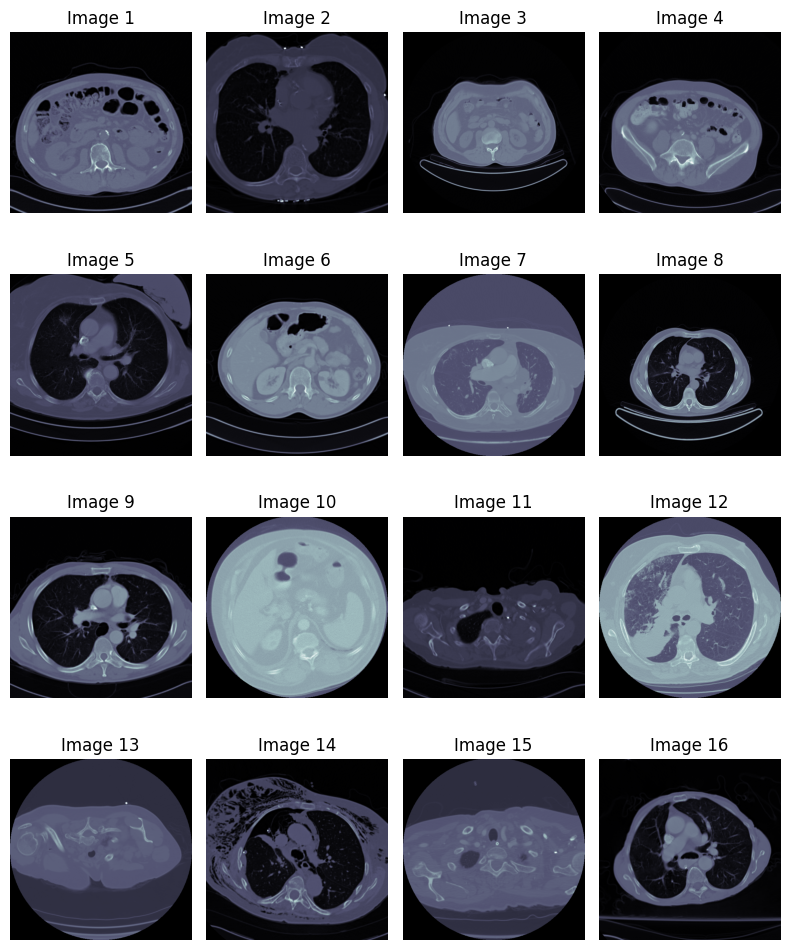

In [5]:
num_images = 16
img_data = list(dicom_data[:num_images].T.to_dict().values())
f, ax = plt.subplots(4, 4, figsize=(8, 10))

print(f"Displaying a sample of {num_images} DICOM images:")
for i, data_row in enumerate(img_data):
    data_row_img = pydicom.dcmread(data_row['path'])
    ax[i//4, i%4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone) 
    ax[i//4, i%4].set_title(f"Image {i+1}")
    ax[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

In [6]:
# DICOM tags from the star schema dimensions
DICOM_TAGS = {
    'PatientID': (0x0010, 0x0020),
    'PatientSex': (0x0010, 0x0040),
    'PatientAge': (0x0010, 0x1010),
    'Manufacturer': (0x0008, 0x0070),
    'Model': (0x0008, 0x1090),
    'StudyDate': (0x0008, 0x0020),
    'Rows': (0x0028, 0x0010),
    'Columns': (0x0028, 0x0011),
    'PixelSpacing': (0x0028, 0x0030),
    'SliceThickness': (0x0018, 0x0050),
    'PhotometricInterp': (0x0028, 0x0004),
    'BodyPart': (0x0018, 0x0015),
    'ContrastAgent': (0x0018, 0x0010),
    'PatientPosition': (0x0018, 0x5100)
}

def extract_metadata(filepath):
    """Reads a DICOM file and extracts required metadata tags."""
    ds = pydicom.dcmread(filepath, force=True)
    metadata = {'file_path': filepath}
    for col, tag in DICOM_TAGS.items():
        try:
            # Get the value, or None if the tag is missing
            metadata[col] = ds[tag].value 
        except KeyError:
            metadata[col] = None
    return metadata

# Apply the extraction to all files
metadata_list = [extract_metadata(p) for p in dicom_data['path']]
df_meta = pd.DataFrame(metadata_list)

display(df_meta.head())

# Check for null or missing values
print("\n--- Validation: Null Values ---")
print(df_meta.isnull().sum().sort_values(ascending=False))

,file_path,PatientID,PatientSex,PatientAge,Manufacturer,Model,StudyDate,Rows,Columns,PixelSpacing,SliceThickness,PhotometricInterp,BodyPart,ContrastAgent,PatientPosition
0,data/dicom_dir/ID_0094_AGE_0052_CONTRAST_0_CT.dcm,TCGA-92-8063,M,052Y,SIEMENS,Sensation 64,20060125,512,512,"[0.697265625, 0.697265625]",3.0,MONOCHROME2,LUNG,None,HFS
1,data/dicom_dir/ID_0059_AGE_0074_CONTRAST_0_CT.dcm,TCGA-17-Z051,F,074Y,SIEMENS,Volume Zoom,19851128,512,512,"[0.55078125, 0.55078125]",5.0,MONOCHROME2,CHEST,None,HFS
2,data/dicom_dir/ID_0085_AGE_0067_CONTRAST_0_CT.dcm,TCGA-17-Z050,M,067Y,SIEMENS,Emotion Duo,19851123,512,512,"[0.9765625, 0.9765625]",5.0,MONOCHROME2,CHEST,None,HFS
3,data/dicom_dir/ID_0017_AGE_0060_CONTRAST_1_CT.dcm,TCGA-17-Z034,M,060Y,SIEMENS,SOMATOM PLUS 4,19830708,512,512,"[007.812500e-01, 007.812500e-01]",5.0,MONOCHROME2,CHEST,None,HFS
4,data/dicom_dir/ID_0048_AGE_0077_CONTRAST_1_CT.dcm,TCGA-17-Z017,F,077Y,SIEMENS,SOMATOM Emotion,19820806,512,512,"[006.074219e-01, 006.074219e-01]",8.0,MONOCHROME2,CHEST,None,HFS



--- Validation: Null Values ---
ContrastAgent        86
PatientID             0
file_path             0
PatientAge            0
Manufacturer          0
Model                 0
PatientSex            0
StudyDate             0
Rows                  0
PixelSpacing          0
Columns               0
SliceThickness        0
PhotometricInterp     0
BodyPart              0
PatientPosition       0
dtype: int64


In [7]:
# Unique patients and sex distribution
df_unique_patients = df_meta[['PatientID', 'PatientSex']].copy()
df_unique_patients = df_unique_patients.drop_duplicates(subset=['PatientID'], keep='first')
total_unique_patients = len(df_unique_patients)

sex_distribution = df_unique_patients['PatientSex'].value_counts(dropna=False)

print(f"Number of unique patients: {total_unique_patients}")
print("Distribution of sex across unique patients:")

print("Sex   | Count | Percentage")
print("------|-------|------------")
for sex, count in sex_distribution.items():
    label = "NaN" if pd.isna(sex) else sex
    percentage = (count / total_unique_patients) * 100
    print(f"{label:<5} | {count:^5} | {percentage:^.2f}%")

Number of unique patients: 54
Distribution of sex across unique patients:
Sex   | Count | Percentage
------|-------|------------
M     |  29   | 53.70%
F     |  25   | 46.30%


Max Patient Age: 83
Min Patient Age: 39


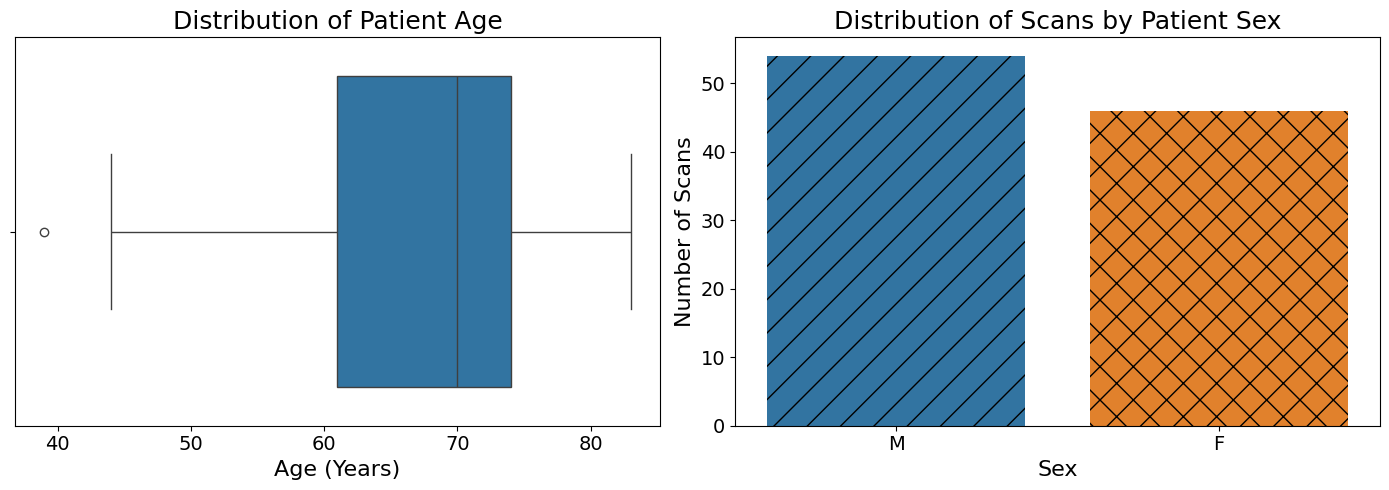

In [8]:
# For the given dataset there are no nulls and the age data is given in years.
# Therefore, we can extract the numerical part ('061Y' -> 61) directly.
df_meta['Age_Years'] = df_meta['PatientAge'].apply(lambda x: int(x[:-1]))

# Max/min values
print(f"Max Patient Age: {df_meta['Age_Years'].max()}")
print(f"Min Patient Age: {df_meta['Age_Years'].min()}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Visualize age distribution (using a boxplot)
sns.boxplot(x=df_meta['Age_Years'], ax=axes[0])
axes[0].set_title('Distribution of Patient Age', fontsize=18)
axes[0].set_xlabel('Age (Years)', fontsize=16)
axes[0].tick_params(axis='both', labelsize=14)

# Visualize age distribution (using a histogram and KDE)
#sns.histplot(df_meta['Age_Years'].dropna(), bins=20, kde=True, ax=axes[0])
#axes[0].set_title('Distribution of Patient Age (Years)', fontsize=14)
#axes[0].set_xlabel('Age', fontsize=14)
#axes[0].set_ylabel('Number of Scans', fontsize=14)

# Visualize sex distribution
sns.countplot(x='PatientSex', data=df_meta, ax=axes[1], hue='PatientSex')
axes[1].set_title('Distribution of Scans by Patient Sex', fontsize=18)
axes[1].set_xlabel('Sex', fontsize=16)
axes[1].set_ylabel('Number of Scans', fontsize=16)
axes[1].tick_params(axis='both', labelsize=14)


hatches = ['/', 'x']
for i, bar in enumerate(axes[1].patches):
    hatch = hatches[i % len(hatches)]
    bar.set_hatch(hatch)
    
plt.tight_layout()
#plt.savefig("patient_distribution.png", dpi=300)
plt.show()

Max Study Date: 2006-07-09 00:00:00
Min Study Date: 1982-06-30 00:00:00


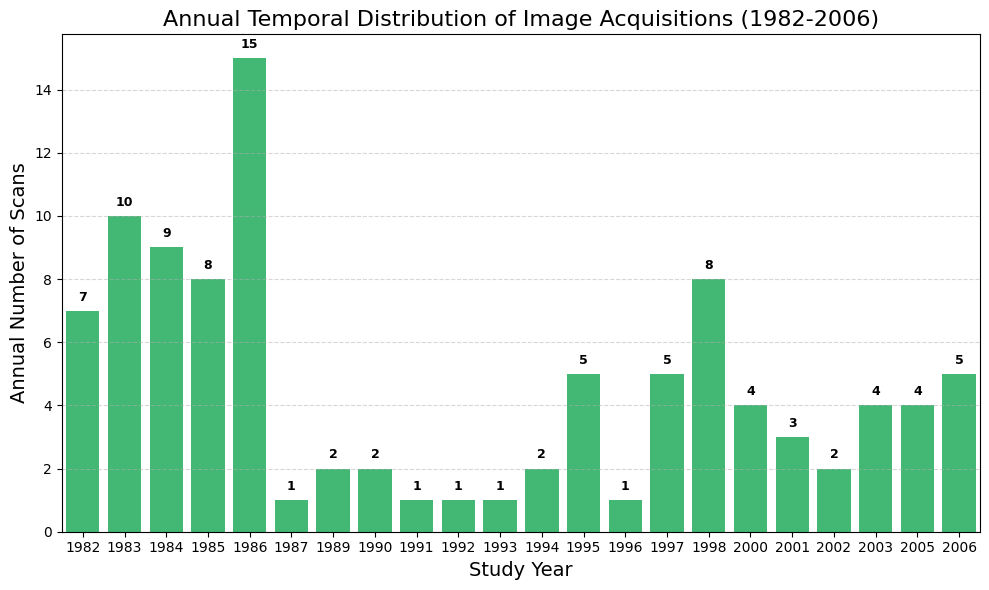

In [9]:
# For the given dataset, the date format is consistent across DICOM files
df_meta['StudyDate'] = pd.to_datetime(df_meta['StudyDate'], format='%Y%m%d', errors='coerce')

# Max/min dates
print(f"Max Study Date: {df_meta['StudyDate'].max()}")
print(f"Min Study Date: {df_meta['StudyDate'].min()}")

# Group by year
df_time_yearly = df_meta.groupby(df_meta['StudyDate'].dt.to_period('Y')).size().reset_index(name='Scan_Count')
df_time_yearly['StudyDate'] = df_time_yearly['StudyDate'].dt.to_timestamp()

df_time_yearly['StudyYear'] = df_time_yearly['StudyDate'].dt.strftime('%Y')
x_labels = df_time_yearly['StudyYear'].tolist()
y_counts = df_time_yearly['Scan_Count'].tolist()

fig, ax = plt.subplots(figsize=(10, 6))

# Visualize image count by year
bars = sns.barplot(x='StudyYear', y='Scan_Count', data=df_time_yearly, ax=ax, color='#2ecc71')

ax.set_title('Annual Temporal Distribution of Image Acquisitions (1982-2006)', fontsize=16)
ax.set_xlabel('Study Year', fontsize=14) 
ax.set_ylabel('Annual Number of Scans', fontsize=14)
plt.xticks(fontsize=10)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_ylim(bottom=0)

# Labels on top of the bars
for bar in bars.patches:
    ax.text(
        bar.get_x() + bar.get_width() / 2., 
        bar.get_height() + (max(y_counts) * 0.015),
        '%d' % int(bar.get_height()), 
        ha='center',
        va='bottom',
        fontsize=9,
        fontweight='bold'
    )

plt.tight_layout()
#plt.savefig("acquisition_distribution.png", dpi=300)
plt.show()

### 3. Transformation & Helper Functions 

This section defines the functions that clean, standardize, and transform the DICOM metadata and pixel data into a format suitable for the dimensional model.

The following functions are implemented:
- `surrogate_key(values)`: Generates a MD5 hash string to serve as the unique surrogate primary key (SK) for the dimension record.
- `get_or_create(collection, values, pk_name)`: Manages dimension records by retrieving the SK if a record exists, or inserting a new one and returning its SK otherwise.
- `format_age(age_str)`: Cleans and converts the DICOM age string (e.g., '061Y') into an integer, handling missing or malformed data with a default value of -1.
- `dicom_to_jpeg(input_path, output_dir, size)`: Extracts the pixel array, normalizes it to 0-255, resizes it to 256×256, and saves it as a grayscale JPEG file, returning the new file path.
- `normalize_pixel_spacing(raw_value)`: Rounds the image's pixel spacing value to the nearest predefined quality bin (0.6, 0.65, etc.).
- `normalize_contrast_agent(val)`: Standardizes the DICOM contrast agent field, replacing null or ambiguous values with "No contrast agent".
- `safe_get_value(ds, tag)`: A utility function to safely retrieve the value of a DICOM tag from a dataset object (ds), preventing KeyError or AttributeError if the tag were to be missing.

In [10]:
def surrogate_key(values):
    """
    Generates a unique MD5 hash string for a dictionary.
    Ensures the same combination of values always produces the same key.
    
    Args:
        values (dict): Dictionary to convert into hash.
        
    Returns:
        str: Hash string.
    """
    # Sort the dictionary items to ensure a consistent order
    sorted_items = sorted(values.items())
    string_representation = str(sorted_items)
    
    # Encode the string to bytes
    encoded_string = string_representation.encode('utf-8')
    # Create and update the MD5 hash object
    md5_hash = hashlib.md5()
    md5_hash.update(encoded_string)
    
    return md5_hash.hexdigest()

def format_age(age_str):
    """
    Transforms a DICOM age string (e.g., '061Y') into an integer
    (e.g., 61). Handles missing or malformed data by returning -1.
    """
    if not age_str:
        return -1
    try:
        # This supposes all the ages are in years 'Y', as in the given dataset
        return int(age_str[:-1])
    except ValueError:
        # Catch cases where the formatting is incorrect
        return -1

def dicom_to_jpeg(input_path, output_dir, size=(256, 256)):
    """
    Reads a DICOM file, normalizes pixel values to 0-255, resizes to 
    a target size, and saves it as a grayscale JPEG, returning the new
    file path.
    
    Args:
        input_path: Full path to the DICOM file.
        output_dir: Directory to save the resulting JPEG.
        size: Tuple (width, height) for resizing.
        
    Returns:
        str: The full path to the saved JPEG file, or None on error.
    """
    try:
        ds = pydicom.dcmread(input_path)
        pixel_array = ds.pixel_array
        
        min_val = pixel_array.min()
        max_val = pixel_array.max()
        
        if max_val == min_val:
            # All pixels have the same value
            normalized_array = np.zeros(pixel_array.shape, dtype=np.uint8)
        else:
            # Normalize (0 to 1) and scale to (0 to 255)
            normalized_array = ((pixel_array - min_val) / (max_val - min_val)) * 255
            normalized_array = normalized_array.astype(np.uint8)

        os.makedirs(output_dir, exist_ok=True)

        # Get output path
        input_filename = os.path.basename(input_path).split('.')[0]
        output_filename = f"{input_filename}_{size[0]}x{size[1]}.jpeg"
        output_path = os.path.join(output_dir, output_filename)
        os.makedirs(output_dir, exist_ok=True)

        # Create 2D PIL Image object
        # As noramlized_array is a 2D array PIL interprets grayscale
        image = Image.fromarray(normalized_array)
        resized_image = image.resize(size)

        # Save image as JPEG
        resized_image.save(output_path, 'JPEG', quality=95)
        
        #print(f"Successfully converted and saved to: {output_path}")
        return output_path
        
    except Exception as e:
        print(f"ERROR converting DICOM {input_path} to JPEG: {e}")
        return None

def normalize_pixel_spacing(raw_value):
    """
    Rounds a numeric pixel spacing value to the nearest bin within a 
    predefined set. Returns -1 for invalid or missing values.
    """
    BINS = [0.6, 0.65, 0.7, 0.75, 0.8]
    try:
        value = float(raw_value)
        
        # Find the bin with the minimum absolute difference
        closest_bin = min(BINS, key=lambda bin_val: abs(value - bin_val))
        
        return closest_bin
    except ValueError:
        # In case the metadata tag is missing
        return -1

def normalize_contrast_agent(val):
    """
    Standardizes DICOM contrast agent metadata. Replaces missing, empty, 
    or single-character values with "No contrast agent".
    """
    if val is None:
        return "No contrast agent"
    
    val = str(val).strip()
    
    if not val or len(val) <= 1:
        return "No contrast agent"
        
    return val

def get_or_create(collection, values, pk_name):
    """
    Checks if a dimension record exists in a MongoDB collection using 
    its surrogate key. If it does not exist, a new record is inserted. 
    Returns the surrogate key in both cases. 

    Args:
        collection (pymongo.collection.Collection): PyMongo Collection object.
        values (dict): Dictionary containing the attributes of the dimension record.
        pk_name (str): The name of the surrogate key field (e.g., "patient_sk").
        
    Returns:
        str: The surrogate key.
    """
    # Calculate the surrogate key
    sk = surrogate_key(values)

    # Filter for the database lookup
    lookup_filter = {pk_name: sk}

    # Check for existence
    existing_document = collection.find_one(lookup_filter)
    
    if existing_document:
        return sk
    else:
        # Document to be inserted
        document = values.copy()
        document[pk_name] = sk

        collection.insert_one(document)
        return sk
        
def safe_get_value(ds, tag):
    """Safely retrieves the value of a DICOM tag (group, element) from a dataset."""
    element = ds.get(tag, None)
    return element.value if element else None

### 4. ETL Loading & Execution

The pipeline iterates through every DICOM file, performs the following steps for each record:

1. **Extract**: Reads the DICOM metadata and pixel data.
2. **Transform & Load (Dimensions)**: Extracts attributes for each dimension (`dim_patient`, `dim_station`, `dim_protocol`, `dim_date`, `dim_image`), applies necessary transformations, and loads the unique dimension records into their respective MongoDB collections, retrieving the surrogate key (SK).
3. **Transform & Load (Fact)**: Extracts measures (`exposure_time`, `tube_current`), performs the required DICOM to JPEG image conversion, and then inserts the final `fact_study` document, linking it to the dimensions using the retrieved SKs.

In [11]:
def load_dim_patient(ds, dim_patient):
    # Extract data
    sex = safe_get_value(ds, (0x0010, 0x0040))
    age_str = safe_get_value(ds, (0x0010, 0x1010)) 
    age_int = format_age(age_str) 
    
    # Dictionary for key generation/insertion
    patient_values = {
        "sex": sex,
        "age": age_int
    }
    
    # Load and Get Surrogate Key
    patient_sk = get_or_create(dim_patient, patient_values, pk_name="patient_sk")
    return patient_sk

def load_dim_station(ds, dim_station):
    manufacturer = safe_get_value(ds, (0x0008,0x0070))
    model = safe_get_value(ds, (0x0008,0x1090))

    station_values = {
        "manufacturer": manufacturer,
        "model": model
    }
    
    station_sk = get_or_create(dim_station, station_values, pk_name="station_sk")
    return station_sk

def load_dim_protocol(ds, dim_protocol):
    body_part = safe_get_value(ds, (0x0018, 0x0015))
    contrast_agent_val = safe_get_value(ds, (0x0018, 0x0010))
    patient_position = safe_get_value(ds, (0x0018, 0x5100))

    contrast_agent = normalize_contrast_agent(contrast_agent_val)

    protocol_values = {
        "body_part": body_part,
        "contrast_agent": contrast_agent,
        "patient_position": patient_position,
    }
    
    protocol_sk = get_or_create(dim_protocol, protocol_values, pk_name="protocol_sk")
    return protocol_sk
    
def load_dim_date(ds, dim_date):
    
    date_str = safe_get_value(ds, (0x0008, 0x0022))

    if not date_str:
        # If date is missing, use -1 for year/month, and None for ID
        date_values = {"year": -1, "month": -1} 
    else:
        try:
            # Parse the YYYYMMDD string into a datetime object
            date_obj = datetime.strptime(date_str, '%Y%m%d') 
            
            date_values = {
                "year": date_obj.year,
                "month": date_obj.month
            }
        except ValueError:
            # Catch malformed strings
            date_values = {"year": -1, "month": -1} 

    date_sk = get_or_create(dim_date, date_values, pk_name="date_sk")
    return date_sk


def load_dim_image(ds, dim_image):
    # Extract image attributes
    rows_val = safe_get_value(ds, (0x0028, 0x0010))
    columns_val = safe_get_value(ds, (0x0028, 0x0011))
    pixel_spacing_val = safe_get_value(ds, (0x0028, 0x0030))
    slice_thickness_val = safe_get_value(ds, (0x0018, 0x0050))
    photometric_interp_val = safe_get_value(ds, (0x0028, 0x0004))
    
    # Transformation
    if hasattr(pixel_spacing_val, '__len__') and len(pixel_spacing_val) >= 2:
        ps_x_raw = str(pixel_spacing_val[0])
        ps_y_raw = str(pixel_spacing_val[1])   
    elif pixel_spacing_val is not None:
        ps_x_raw = ps_y_raw = str(pixel_spacing_val)

    # Apply the normalization helper function to bin the spacing values
    ps_x_clean = normalize_pixel_spacing(ps_x_raw) 
    ps_y_clean = normalize_pixel_spacing(ps_y_raw)

    image_values = {
        "rows": rows_val,
        "columns": columns_val,
        "pixel_spacing_x": ps_x_clean,
        "pixel_spacing_y": ps_y_clean,
        "slice_thickness": slice_thickness_val,
        "photometric_interp": photometric_interp_val,
    }
    
    # Load and get the surrogate key
    image_sk = get_or_create(dim_image, image_values, pk_name="image_sk")
    return image_sk

def load_fact_study(file_path, fact_study, dim_patient, dim_station, dim_protocol, dim_date, dim_image):
    """
    Orchestrates the ETL process for a single DICOM file:
        1. Reads the DICOM file.
        2. Loads dimension records and retrieves their surrogate keys (SKs).
        3. Extracts remaining fact data and constructs the fact document.
        4. Inserts the fact document into the fact table.

    Args:
        file_path (str): Full path to the DICOM file.
        fact_study (pymongo.collection.Collection): MongoDB fact table collection.
        dim_patient, dim_station, etc. (pymongo.collection.Collection): Dimension collections.
    """
    try:
        ds = pydicom.dcmread(file_path)
        
        # Load dimension tables and retrieve surrogate keys
        patient_sk = load_dim_patient(ds, dim_patient)
        station_sk = load_dim_station(ds, dim_station)
        protocol_sk = load_dim_protocol(ds, dim_protocol)
        date_sk = load_dim_date(ds, dim_date)
        image_sk = load_dim_image(ds, dim_image)

        # Extract fact data
        exposure_time = safe_get_value(ds, (0x0018, 0x1150))
        tube_current = safe_get_value(ds, (0x0018, 0x1151))

        # The relative path to the JPEG file
        jpeg_path = dicom_to_jpeg(file_path, JPEG_PATH)
        if not JPEG_PATH:
            # Skip the process for this file if image conversion failed
            print(f"Skipping fact load for {os.path.basename(file_path)}: JPEG conversion failed.")
            return

        study_values = {
            # Surrogate keys from dimensions
            "station_sk": station_sk,
            "patient_sk": patient_sk,
            "image_sk": image_sk,
            "protocol_sk": protocol_sk,
            "study_date": date_sk,
            
            # Attributes
            "exposure_time": exposure_time,
            "tube_current": tube_current,
            "file_path": jpeg_path
        }
        # Load the fact table
        image_sk = get_or_create(fact_study, study_values, pk_name="study_sk")
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")

In [12]:
def run_etl_pipeline():
    """
    Connects to MongoDB, defines collections, and runs the ETL process 
    for all DICOM files.
    """
    print(f"Connecting to MongoDB at: {MONGO_URI}")
    client = None # Initialize client outside try block
    
    try:
        # Establish connection
        client = MongoClient(MONGO_URI)
        client.admin.command('ping')
        print("Successfully connected to MongoDB.")

        # Define database and collections
        db = client[DB_NAME]
        
        # Fact table
        fact_study = db["fact_study"] 
        
        # Dimension tables
        dim_patient = db["dim_patient"]
        dim_station = db["dim_station"]
        dim_protocol = db["dim_protocol"]
        dim_date = db["dim_date"]
        dim_image = db["dim_image"]

        # Find DICOM files
        dicom_file_paths = glob(DICOM_FILES_PATTERN)
        total_files = len(dicom_file_paths)
        print(f"Found {total_files} DICOM files to process.")
        
        # Iterate and load
        for i, file_path in enumerate(dicom_file_paths):
            load_fact_study(
                file_path, 
                fact_study, 
                dim_patient, 
                dim_station, 
                dim_protocol, 
                dim_date, 
                dim_image
            )
            if (i + 1) % 50 == 0:
                print(f"--- Processed {i + 1} of {total_files} files. ---")

        print("ETL pipeline completed successfully.")

    except Exception as e:
        print(f"FATAL ERROR: Pipeline failed")
        print(e)
        
    finally:
        if client:
            client.close()
            print("MongoDB connection closed.")

In [13]:
run_etl_pipeline()

Connecting to MongoDB at: mongodb://localhost:27017
Successfully connected to MongoDB.
Found 100 DICOM files to process.
--- Processed 50 of 100 files. ---
--- Processed 100 of 100 files. ---
ETL pipeline completed successfully.
MongoDB connection closed.
